# Occular OCR Demo

**DBNet** (детекция) + **CRNN MobileNetV3-Large** (распознавание, CER=1.53%)

Модель обучена на русскоязычных книжных страницах. ONNX Runtime по умолчанию (~1 сек/страница на CPU).

## 1. Базовое использование (для начинающих)

Всего 3 строки кода:

Размер: 679x1080 px


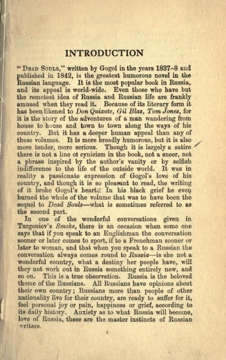

In [1]:
from PIL import Image

# Страница которую будем распознавать
IMAGE_PATH = '/home/user/dataset/pages/deadsouls00gogouoft/page_0009.png'
img = Image.open(IMAGE_PATH)
print(f"Размер: {img.size[0]}x{img.size[1]} px")
img.resize((img.width // 3, img.height // 3))

In [2]:
from ocr_skel import ocr

# Распознаём текст из изображения
text = ocr(IMAGE_PATH)

print(text[:500])
print("...")
print(f"\n[Всего {len(text)} символов]")

Loaded DBNet ONNX
Loaded CRNN ONNX (vocab=298 chars)
INTRODUCTION
“ DEAD SouLs," written by Gogol in the years 1887–8 and
published in 1842, is the greatest humorous novel in the
Russian language. It is the most popular book in Russia,
and its appeal is world-wide. Even those who have but
the remotest idea of Russia and Russian life are frankly
amused when they read it. Because of its literary form it
has been likened to Don Quixote, Gil Blas, Tom Jones, for
it is the story of the adventures of a man wandering from
house to house and town to town 
...

[Всего 2019 символов]


### PDF — тоже 1 строка

In [3]:
# Для PDF возвращается список строк (по одной на страницу)
pages = ocr('/home/user/Yandex.Disk/Добро Пожаловать.pdf')

print(f"Страниц в PDF: {len(pages)}\n")
print("--- Страница 1 ---")
print(pages[0][:300])
print("...")

Страниц в PDF: 4

--- Страница 1 ---
Добро пожаловать
в Яндекс.Диск
Мы рады приветствовать вас на борту Яндекс.Диска!
Этот файл поможет вам познакомиться с сервисом
и узнать, что ожидает вас в полете.
Яндекс.Диск — это бесплатный сервис для хранения ваших файлов
и работы с ними на любом устройстве, подключенном к интернету.
Используйте
...


## 2. Продвинутое использование

Класс `OCRPipeline` даёт полный контроль над настройками:

In [10]:
from ocr_skel import OCRPipeline

# Создаём pipeline с настройками
pipeline = OCRPipeline(
    onnx=True,   # ONNX Runtime (по умолчанию, быстрее на CPU)
    gpu=False    # CPU режим
)

# Получаем детальные результаты с координатами (уже отсортированы по Y)
results = pipeline.process_image(IMAGE_PATH)

print(f"Найдено {len(results)} текстовых областей:\n")
for r in results[:5]:
    print(f"  • '{r['text'][:50]}...' (conf: {r['confidence']:.1%})")
print(f"\n  ... и ещё {len(results) - 5} областей")

Найдено 38 текстовых областей:

  • 'INTRODUCTION...' (conf: 87.4%)
  • '“ DEAD SouLs," written by Gogol in the years 1887–...' (conf: 56.3%)
  • 'published in 1842, is the greatest humorous novel ...' (conf: 51.3%)
  • 'Russian language. It is the most popular book in R...' (conf: 50.7%)
  • 'and its appeal is world-wide. Even those who have ...' (conf: 55.2%)

  ... и ещё 33 областей


### PDF с параллельной обработкой

In [5]:
# PDF с настройками
# results = pipeline.process_pdf(
#     'document.pdf',
#     dpi=300,         # Высокое разрешение для мелкого текста
#     workers=4,       # 4 параллельных воркера
#     force_ocr=True   # OCR даже для векторных PDF
# )

# Или просто получить текст
# text = pipeline.get_text('document.pdf')

print("PDF параметры: dpi, workers, force_ocr")

PDF параметры: dpi, workers, force_ocr


### Визуализация детекции

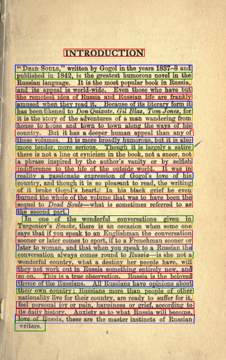

In [6]:
from PIL import ImageDraw

img_result = Image.open(IMAGE_PATH).copy()
draw = ImageDraw.Draw(img_result)

colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, r in enumerate(results):
    color = colors[i % len(colors)]
    quad = r['quad']
    points = [tuple(p) for p in quad] + [tuple(quad[0])]
    draw.line(points, fill=color, width=2)

# Показываем уменьшенную версию
img_result.resize((img_result.width // 3, img_result.height // 3))

## 3. Использование из командной строки (CLI)

После установки (`pip install -e .`) доступна команда `ocr`:

In [7]:
%%bash
# Базовое использование
echo "=== Базовые команды ==="
echo "ocr photo.png                    # Распознать изображение"
echo "ocr document.pdf                 # Распознать PDF"
echo ""
echo "=== С опциями ==="
echo "ocr scan.pdf --workers 4         # 4 воркера для PDF"
echo "ocr photo.png --json             # Вывод с координатами"
echo "ocr photo.png -o result.json     # Сохранить в файл"
echo ""
echo "=== Справка ==="
echo "ocr --help"

=== Базовые команды ===
ocr photo.png                    # Распознать изображение
ocr document.pdf                 # Распознать PDF

=== С опциями ===
ocr scan.pdf --workers 4         # 4 воркера для PDF
ocr photo.png --json             # Вывод с координатами
ocr photo.png -o result.json     # Сохранить в файл

=== Справка ===
ocr --help


### Пример вызова CLI

In [8]:
!cd /home/user/occular-ocr && python -m ocr_skel.cli /home/user/dataset/pages/deadsouls00gogouoft/page_0009.png 2>/dev/null | head -20

## 4. Скорость работы

In [9]:
import time

# Прогрев
_ = pipeline.process_image(IMAGE_PATH)

# Замер времени
start = time.time()
for _ in range(5):
    _ = pipeline.process_image(IMAGE_PATH)
avg_time = (time.time() - start) / 5

print(f"Среднее время на страницу: {avg_time:.2f} сек")
print(f"На 100 страниц PDF: ~{avg_time * 100 / 60:.1f} мин")

Среднее время на страницу: 1.14 сек
На 100 страниц PDF: ~1.9 мин
